In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Project root = parent directory of notebooks/
PROJECT_ROOT = Path().resolve().parent

# Data directories
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

# Copy to avoid side effects
df = pd.read_csv(DATA_PROCESSED / "all_events_results_clean.csv", parse_dates=["date"])

In [2]:
### Basic sanity checks & missingness

# Missing values overview
missing = (
    df.isna()
      .mean()
      .sort_values(ascending=False)
      .rename("missing_ratio")
)

display(missing.to_frame())

# Check date range
print("Date range:", df["date"].min(), "→", df["date"].max())

,missing_ratio
auto_raw,0.969727
wind,0.946940
mark_raw,0.841471
mark_meters,0.841471
time_seconds,0.158854
time_raw,0.158529
nationality,0.078125
date,0.000326
event,0.000000
sex,0.000000


Date range: 1827-09-26 00:00:00 → 2025-09-15 00:00:00


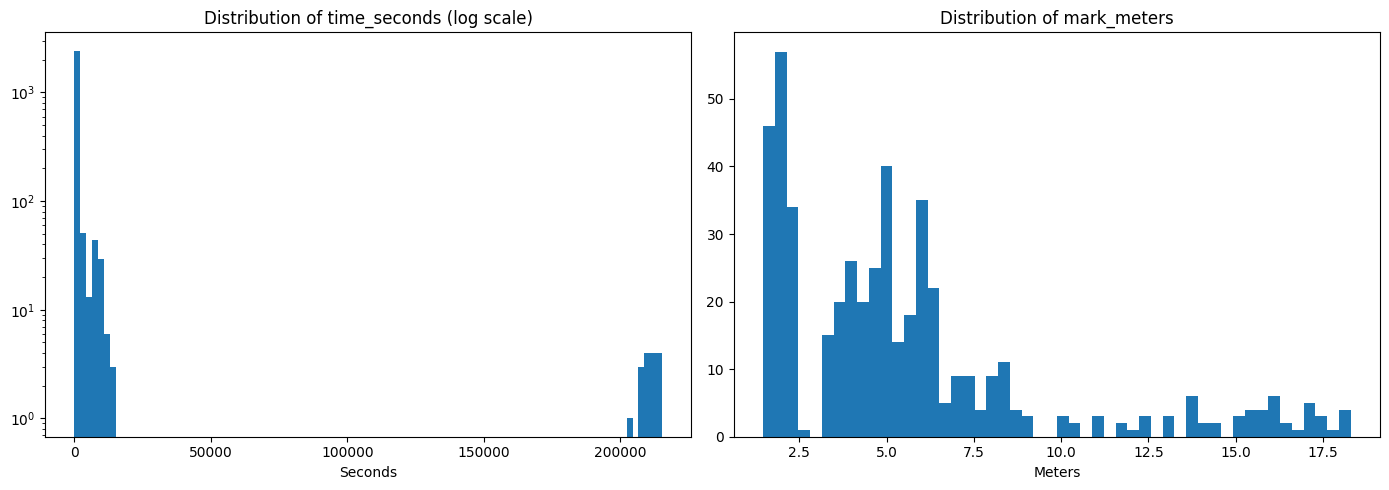

In [3]:
### Distribution analysis (time & distance)

# Separate running/swimming (time) vs jumping (distance)
time_df = df[df["time_seconds"].notna()]
jump_df = df[df["mark_meters"].notna()]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(time_df["time_seconds"], bins=100)
axes[0].set_yscale("log")
axes[0].set_title("Distribution of time_seconds (log scale)")
axes[0].set_xlabel("Seconds")

axes[1].hist(jump_df["mark_meters"], bins=50)
axes[1].set_title("Distribution of mark_meters")
axes[1].set_xlabel("Meters")

plt.tight_layout()
plt.show()

In [6]:
### Yearly best progression (trend backbone)

# Extract year
df["year"] = df["date"].dt.year

# One unified performance column
df["performance"] = np.where(df["category"] == "jump", df["mark_meters"], df["time_seconds"])

# Create a score where higher is always better:
# - jump: score = meters (higher better)
# - time: score = -seconds (lower seconds => higher score)
df["score"] = np.where(df["category"] == "jump", df["performance"], -df["performance"])

# Keep only rows with usable performance
df_valid = df.dropna(subset=["performance", "score", "year"])

# Yearly best per (event, sex, year): highest score is best
yearly_best = (
    df_valid.sort_values("score", ascending=False)
            .groupby(["event", "sex", "year"], as_index=False)
            .first()
)

display(yearly_best[["event","sex","year","category","subcategory","performance","score"]].head(10))


,event,sex,year,category,subcategory,performance,score
0,10000m,men,1847.0,run,long,1955.0,-1955.0
1,10000m,men,1882.0,run,long,1929.0,-1929.0
2,10000m,men,1884.0,run,long,1900.0,-1900.0
3,10000m,men,1885.0,run,long,1883.1,-1883.1
4,10000m,men,1904.0,run,long,1862.4,-1862.4
5,10000m,men,1911.0,run,long,1858.8,-1858.8
6,10000m,men,1921.0,run,long,1840.2,-1840.2
7,10000m,men,1924.0,run,long,1806.2,-1806.2
8,10000m,men,1937.0,run,long,1805.6,-1805.6
9,10000m,men,1938.0,run,long,1802.0,-1802.0


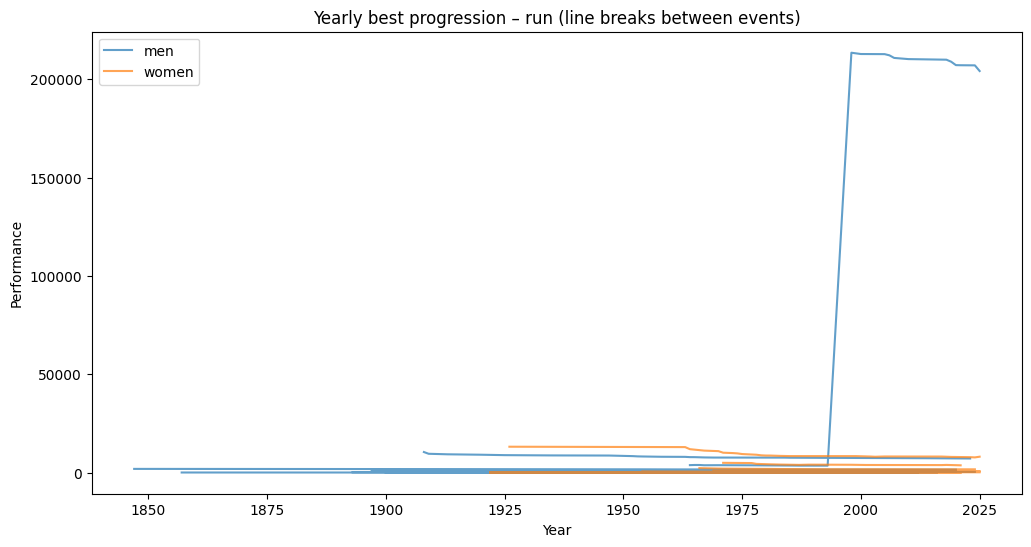

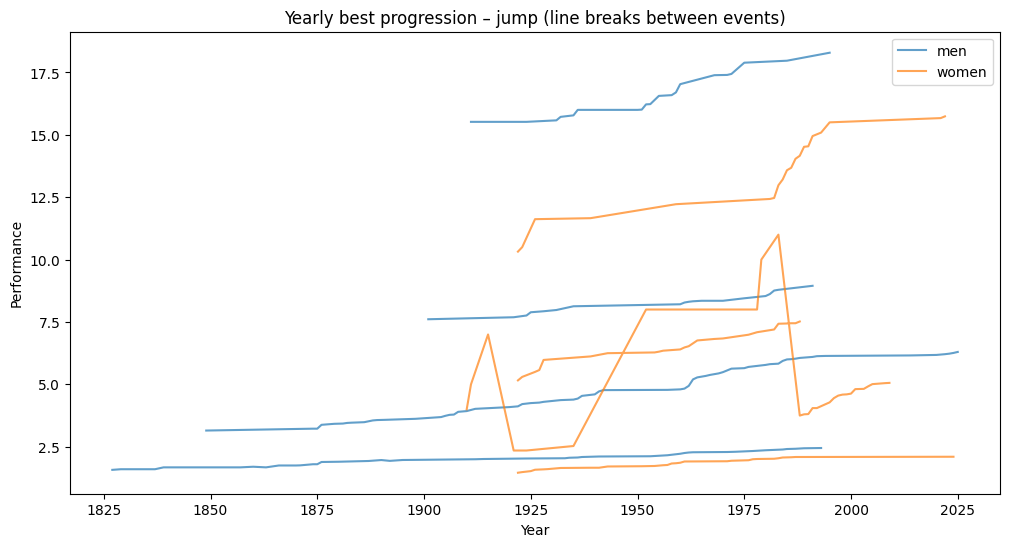

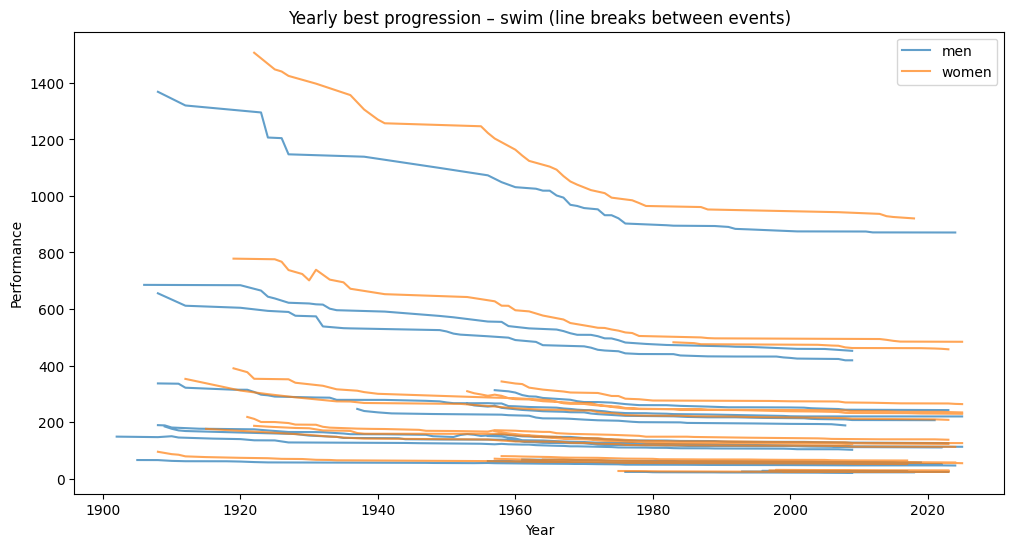

In [12]:
for cat in yearly_best["category"].unique():
    subset = yearly_best[yearly_best["category"] == cat].copy()

    plt.figure(figsize=(12, 6))

    for sex in subset["sex"].unique():
        chunks = []
        for event, g in subset[subset["sex"] == sex].groupby("event"):
            g = g.sort_values("year")[["year", "performance"]].copy()
            chunks.append(g)
            # separator row -> breaks the line
            chunks.append(pd.DataFrame({"year": [np.nan], "performance": [np.nan]}))

        s = pd.concat(chunks, ignore_index=True)
        plt.plot(s["year"], s["performance"], label=sex, alpha=0.7)

    plt.title(f"Yearly best progression – {cat} (line breaks between events)")
    plt.xlabel("Year")
    plt.ylabel("Performance")
    plt.legend()
    plt.show()


In [ ]:
### Improvement rate estimation (linear trend)

from scipy.stats import linregress

improvement_rates = []

for (event, sex), g in yearly_best.groupby(["event", "sex"]):
    if g["year"].nunique() < 10:
        continue
    
    slope, intercept, r, p, stderr = linregress(g["year"], g["performance"])
    
    improvement_rates.append({
        "event": event,
        "sex": sex,
        "slope": slope,
        "r2": r**2,
        "n_years": g["year"].nunique()
    })

rates_df = pd.DataFrame(improvement_rates)
display(rates_df.sort_values("slope"))


In [ ]:
### Gender comparison of improvement rates

pivot_rates = (
    rates_df
    .pivot(index="event", columns="sex", values="slope")
    .dropna()
)

pivot_rates["women_minus_men"] = pivot_rates["women"] - pivot_rates["men"]

display(
    pivot_rates
    .sort_values("women_minus_men", ascending=False)
)


In [ ]:
### Outlier detection (potential data issues)

yearly_best["delta"] = (
    yearly_best
    .groupby(["event", "sex"])["performance"]
    .diff()
)

# Large sudden changes
anomalies = yearly_best[
    yearly_best["delta"].abs() > yearly_best["delta"].std() * 5
]

display(anomalies.sort_values("delta", ascending=False).head(20))


In [ ]:
### Performance normalization (cross-event comparison)

yearly_best["zscore"] = (
    yearly_best
    .groupby(["event", "sex"])["performance"]
    .transform(lambda x: (x - x.mean()) / x.std())
)

plt.figure(figsize=(10, 5))
for sex in ["men", "women"]:
    s = yearly_best[yearly_best["sex"] == sex]
    plt.plot(s["year"], s["zscore"], label=sex, alpha=0.4)

plt.title("Normalized performance trends (z-score)")
plt.legend()
plt.show()
